c(x, t) = M/A * 1 / (2*sqrt(pi*D)) * x / t^(3/2) * exp(- (ut - x) ^ 2 / (4*D*t))

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from open_atmos_jupyter_utils import show_plot
from scipy import constants as const
import pint

# Set up units
si = pint.UnitRegistry()
si.setup_matplotlib()

In [2]:
# Define the function to plot
def concentration(x, t, M, A, D, u):
    """Calculate concentration based on the given formula.
    
    Parameters:
    x: distance [m]
    t: time [s]
    M: mass [kg]
    A: area [m^2]
    D: diffusion coefficient [m^2/s]
    u: velocity [m/s]
    """
    return (M/A) * (1/(2*np.sqrt(np.pi*D))) * (x/t**(3/2)) * np.exp(-((u*t - x)**2)/(4*D*t))

In [15]:
# Parameter search function
from scipy.optimize import minimize

def search_parameters(target_concentration=0.04, fixed_time=50.0 * si.s):
    """
    Find parameters that make the concentration function reach target_concentration at fixed_time.
    
    Returns:
        Dictionary with the found parameters
    """
    # Define objective function (difference between calculated and target concentration)
    def objective(params):
        x, M, A, D, u = params
        # Convert to quantities with units
        x_val = x * si.m
        M_val = M * si.kg
        A_val = A * si.m**2
        D_val = D * si.m**2/si.s
        u_val = u * si.m/si.s
        
        # Calculate concentration (strip units to work with scipy's optimizer)
        calc_conc = concentration(x_val, fixed_time, M_val, A_val, D_val, u_val)
        
        # Return squared difference between calculated and target
        return ((calc_conc.magnitude - target_concentration) ** 2)
    
    # Initial parameter guesses
    initial_guess = [25.0, 1.0, 1.0, 0.1, 0.5]  # [x, M, A, D, u]
    
    # Parameter bounds (all parameters must be positive)
    bounds = [(0.1, 100), (0.1, 10), (0.1, 10), (0.01, 1), (0.1, 5)]
    
    # Run optimization
    result = minimize(objective, initial_guess, bounds=bounds, method='L-BFGS-B', tol=1e-20)
    
    # Extract optimized parameters
    x_opt, M_opt, A_opt, D_opt, u_opt = result.x
    
    # Convert to quantities with units
    params = {
        'x': x_opt * si.m,
        'M': M_opt * si.kg,
        'A': A_opt * si.m**2,
        'D': D_opt * si.m**2/si.s,
        'u': u_opt * si.m/si.s,
        't': fixed_time,
        'success': result.success,
        'concentration': concentration(x_opt * si.m, fixed_time, M_opt * si.kg, 
                                      A_opt * si.m**2, D_opt * si.m**2/si.s, u_opt * si.m/si.s)
    }
    
    return params

params = search_parameters()
print(f"Found parameters: x={params['x']}, M={params['M']}, A={params['A']}, D={params['D']}, u={params['u']}")
print(f"Resulting concentration: {params['concentration']}")
print(f"Optimization success: {params['success']}")

# Validate the result
target = 0.04
error = abs(params['concentration'].magnitude - target)
print(f"Error from target of {target}: {error:.10f}")

Found parameters: x=24.99824934159211 meter, M=0.955597011823584 kilogram, A=1.0422818933210205 meter ** 2, D=0.2089829319147844 meter ** 2 / second, u=0.5009231111802378 meter / second
Resulting concentration: 0.03999999999989218 kilogram / meter ** 2 / second
Optimization success: True
Error from target of 0.04: 0.0000000000


In [16]:
x = 24.99824934159211 * si.m
M = 0.955597011823584 * si.kg  # mass
A = 1.0422818933210205 * si.m**2  # area
D = 0.2089829319147844 * si.m**2/si.s  # diffusion coefficient
u = 0.5009231111802378 * si.m/si.s  # velocity

In [19]:
def plot_concentration_vs_time(fig):
    t_range = np.linspace(1, 100, 500) * si.s  # Avoid t=0 to prevent division by zero
    
    ax = fig.gca()
    c = concentration(x, t_range, M, A, D, u)
    ax.plot(t_range, c)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Concentration (kg/m³)')
    ax.set_title('Concentration vs Time for Different Distances')
    ax.legend()

/tmp/ipykernel_205473/3053557067.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


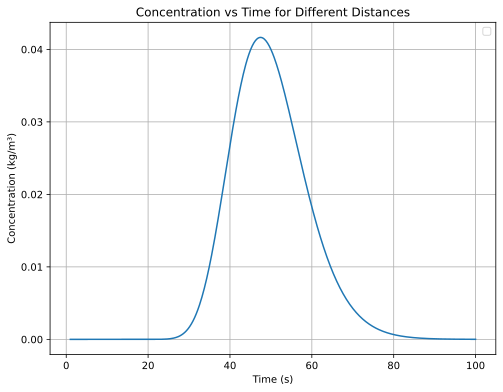

In [20]:
# Create and show the second plot (concentration vs time)
fig2 = plt.figure(figsize=(8, 6))
plot_concentration_vs_time(fig2)
show_plot(fig=fig2)